In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import string

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

For this project I am interested in understanding listing features driving higher AirBnB prices. How can AirBnB hosts bring out the best existing qualities of their listings? How can they know if their pricing is fair compared to market? 

This piece of analysis is broken down into two parts to answer the questions:
* What is a fair price for each listing?
* How can they bring out the best qualities of their listing through accurate description?

![](http://)**1. Data Overview and Preprocessing**

In [4]:
airbnb = pd.read_csv("AB_NYC_2019.csv")

In [5]:
print("\nData size: \n", airbnb.shape)
print("\nData types: \n", airbnb.dtypes)
print("\nFeatures: \n", airbnb.columns)
print("\nMissing Values :", airbnb.isnull().sum())
print("\nUnique Values :", airbnb.nunique())


Data size: 
 (48895, 16)

Data types: 
 id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Features: 
 Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count'

In [6]:
# separate our table from original table for further manipulation
airbnb_df = airbnb

# convert date into day, month, and year columns
airbnb_df.last_review = pd.to_datetime(airbnb.last_review)
airbnb_df["last_review_day"] = airbnb_df.last_review.dt.day
airbnb_df["last_review_month"] = airbnb_df.last_review.dt.month
airbnb_df["last_review_year"] = airbnb_df.last_review.dt.year

In [7]:
# do all the missing values occur at the same index?
last_review_missing = pd.isnull(airbnb_df["last_review"])
reviews_per_month_missing = pd.isnull(airbnb_df["reviews_per_month"])
print("Do all missing values occur at the same index?")
print(np.array_equal(last_review_missing,reviews_per_month_missing))

# create a new flag to tag these listings as new listings 
airbnb_df["new_listing_flag"] = np.where(last_review_missing, 1, 0)

Do all missing values occur at the same index?
True


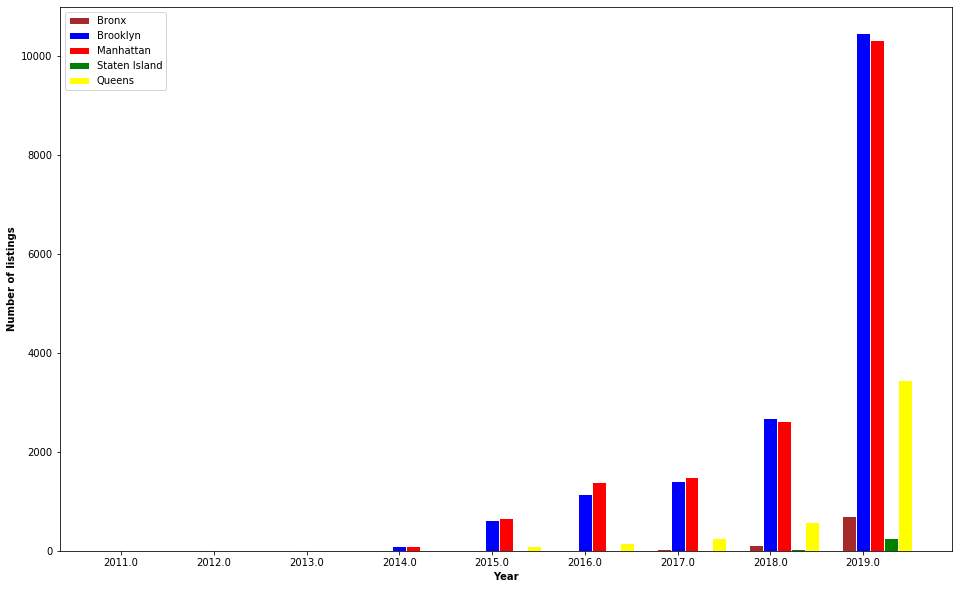

In [8]:
time_trend_count = airbnb_df.groupby([ "neighbourhood_group","last_review_year"])["id"].count().reset_index()
time_trend_count.set_index(["last_review_year"]).reset_index().sort_values(by=["neighbourhood_group","last_review_year"])

time_trend_count = pd.DataFrame(time_trend_count)
time_trend_count = pd.pivot_table(time_trend_count,values="id",columns="neighbourhood_group",index="last_review_year").fillna(value=0)

plt.figure(figsize=(16, 10))

barWidth = 0.15  # the width of the bar
# set height of bar
bars1 = time_trend_count["Bronx"].tolist()
bars2 = time_trend_count["Brooklyn"].tolist()
bars3 = time_trend_count["Manhattan"].tolist()
bars4 = time_trend_count["Staten Island"].tolist()
bars5 = time_trend_count["Queens"].tolist()

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

plt.bar(r1, bars1, color='brown', width=barWidth, edgecolor='white', label='Bronx')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='Brooklyn')
plt.bar(r3, bars3, color='red', width=barWidth, edgecolor='white', label='Manhattan')
plt.bar(r4, bars4, color='green', width=barWidth, edgecolor='white', label='Staten Island')
plt.bar(r5, bars5, color='yellow', width=barWidth, edgecolor='white', label='Queens')

plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of listings', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], time_trend_count.index)

plt.legend()
plt.show()


Here I set the assumption that "last_review_year" older than 2018 are inactive listings. We will focus the rest of the analysis on the active listings.  

In [9]:
airbnb_df = airbnb_df[ (airbnb_df["last_review_year"] > 2017) | (airbnb_df["new_listing_flag"] == 1)]

**2. Analysis**

/Users/Bellyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


  neighbourhood_group  new_listing_flag  Count  Min    Max  Median         Std
0       Staten Island                 1     59   29   5000      95  670.663296
1       Staten Island                 0    303   13    300      72   54.824919
2              Queens                 1   1092   11   2350      80  160.845636
3              Queens                 0   4046   10   2600      70   80.371149
4           Manhattan                 1   5029    0  10000     175  438.376573
5           Manhattan                 0  12952   10   8500     145  193.220898
6            Brooklyn                 1   3657   10   6500      85  249.066062
7            Brooklyn                 0  13141    0   7500      95  131.927297
8               Bronx                 1    215   10   2500      77  199.899692
9               Bronx                 0    817    0    670      65   60.614690


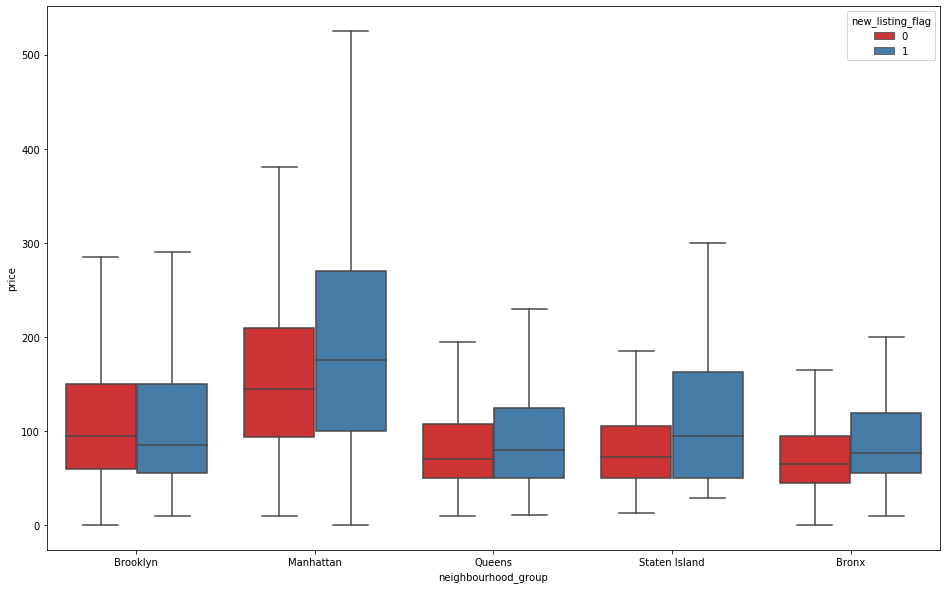

In [10]:
price_by_neighbourhood = airbnb_df.groupby(["neighbourhood_group","new_listing_flag"])["price"].agg({'Count':'count','Min': 'min',
                             'Max': 'max', 'Median':'median', 'Std':'std'})

price_by_neighbourhood = price_by_neighbourhood.sort_values(by=["neighbourhood_group","new_listing_flag"], ascending = False).reset_index()
print(price_by_neighbourhood)

# Grouped boxplot
df = pd.DataFrame(airbnb_df[["price","neighbourhood_group", "new_listing_flag"]])
plt.figure(figsize=(16, 10))
sns.boxplot(x="neighbourhood_group", y="price", hue="new_listing_flag", data=df, palette="Set1", showfliers=False)

This chart gives a sense of scale of the Airbnb listing space. Manhattan has the most expensive listings, followed by Brooklyn. New listings are overall more expensive than existing listings. 

In [11]:
# Within each neighborhood group, which are the most expensive?

neighborhood = airbnb_df.groupby(["neighbourhood_group","neighbourhood"])["price"].agg({'Count':'count','Min': 'min',
                             'Max': 'max', 'Median':'median', 'Std':'std'})

neighborhood[neighborhood["Count"]>100].sort_values(by="Median", ascending = False).groupby("neighbourhood_group").head(5)

/Users/Bellyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  after removing the cwd from sys.path.


Count  Min   Max  Median         Std
neighbourhood_group neighbourhood                                           
Manhattan           Tribeca               150   60  8500   301.5  905.337342
                    Midtown              1334   48  5100   215.0  249.022322
                    Financial District    671   12  3000   210.0  173.971615
                    Greenwich Village     307   43  6000   200.0  443.631605
                    West Village          608   50  4000   200.0  296.910631
Brooklyn            Boerum Hill           138   46  1000   150.0  141.080388
                    Brooklyn Heights      121   45  1500   150.0  207.251372
                    Carroll Gardens       180   40  1395   150.0  136.126791
                    Park Slope            409   30  2626   145.0  181.166371
                    South Slope           223   40   500   134.0   83.913805
Queens              Long Island City      466   30  2000    99.0  131.483223
                    Forest Hills          126   16  2350    88.0  224.744029
                    Astoria               751   25  2000    85.0  106.572340
                    Ditmars Steinway      267   29   600    80.0   65.765041
                    Sunnyside             318   12   600    75.0   54.631284

In [12]:
# Popularity of listing
number_of_reviews_bins = [1,10,20,40,60,80,100,float("inf")]
number_of_review_labels = ["<10","10-19","20-39","40-59","60-79","80-99",">100"]
airbnb_df['binned_reviews'] = pd.cut(airbnb_df['number_of_reviews'], bins = number_of_reviews_bins, labels = number_of_review_labels)
airbnb_df[["number_of_reviews", "binned_reviews"]].dropna().groupby("binned_reviews").count()

/Users/Bellyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,number_of_reviews
binned_reviews,
<10,10904
10-19,4621
20-39,4529
40-59,2500
60-79,1646
80-99,1097
>100,2968


/Users/Bellyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


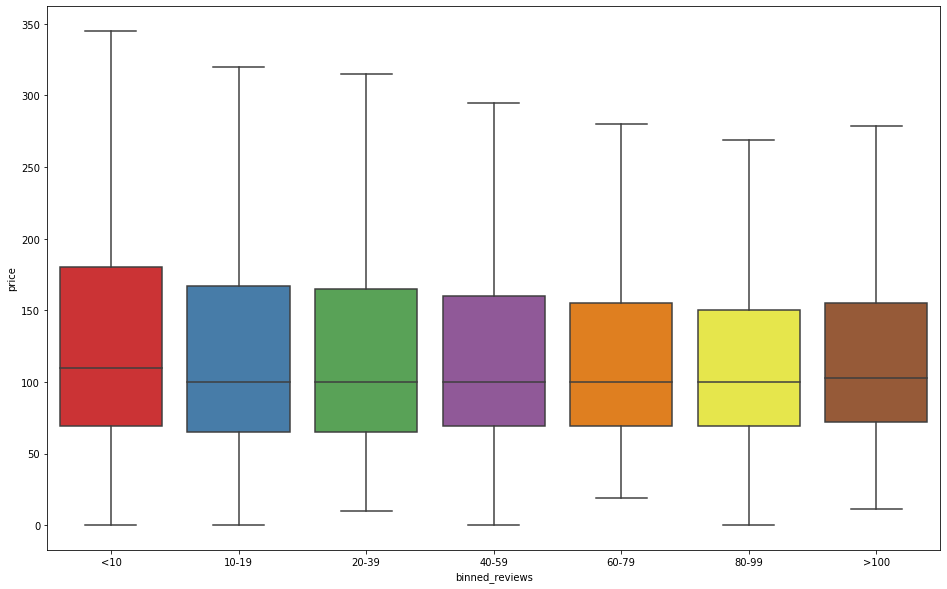

In [13]:
reviews = airbnb_df.groupby("binned_reviews")["price"].agg({'Count':'count','Min': 'min',
                             'Max': 'max', 'Median':'median', 'Std':'std'})

# Grouped boxplot
reviews_boxplot = pd.DataFrame(airbnb_df[["binned_reviews","price"]])
plt.figure(figsize=(16, 10))
sns.boxplot(x="binned_reviews", y="price", data=reviews_boxplot, palette="Set1", showfliers=False)

Most airbnb listings have less than 10 cumulative reviews. The number of reviews per listing doesn't seem to affect the price.


In [14]:
# Popularity of listing
reviews_per_month_bins = [0,5,10,20,50,100,float("inf")]
# reviews_per_month_labels = ["<10","10-19","20-39","40-59","60-79","80-99",">100"]
airbnb_df['binned_reviews_per_month'] = pd.cut(airbnb_df['number_of_reviews'], bins = reviews_per_month_bins)#, labels = reviews_per_month_labels)
airbnb_df[["reviews_per_month", "binned_reviews_per_month"]].dropna().groupby("binned_reviews_per_month").count()

/Users/Bellyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,reviews_per_month
binned_reviews_per_month,
"(0.0, 5.0]",9537
"(5.0, 10.0]",4361
"(10.0, 20.0]",4621
"(20.0, 50.0]",5903
"(50.0, 100.0]",3869
"(100.0, inf]",2968


/Users/Bellyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


                          Count  Min   Max  Median         Std
binned_reviews_per_month                                      
(0.0, 5.0]                 9537    0  8500     109  200.712081
(5.0, 10.0]                4361   10  7500     110  181.987660
(10.0, 20.0]               4621    0  2500     100  137.686221
(20.0, 50.0]               5903   10  2300     100  125.369434
(50.0, 100.0]              3869    0  2990     100  111.237057
(100.0, inf]               2968   11  1195     103   87.148264


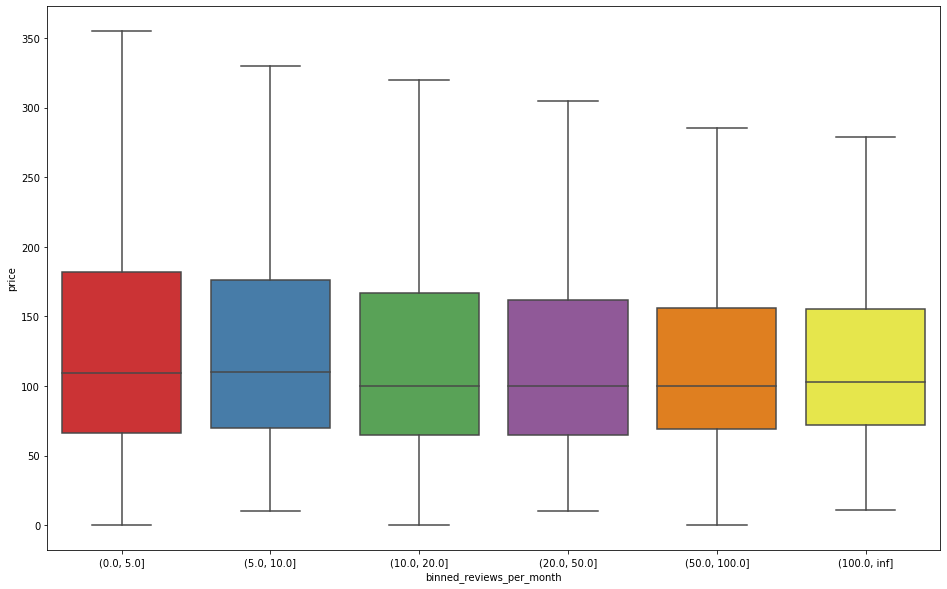

In [15]:
reviews_per_month = airbnb_df.groupby("binned_reviews_per_month")["price"].agg({'Count':'count','Min': 'min',
                             'Max': 'max', 'Median':'median', 'Std':'std'})

print(reviews_per_month)
# Grouped boxplot
reviews_boxplot = pd.DataFrame(airbnb_df[["binned_reviews_per_month","price"]])
plt.figure(figsize=(16, 10))
sns.boxplot(x="binned_reviews_per_month", y="price", data=reviews_boxplot, palette="Set1", showfliers=False)

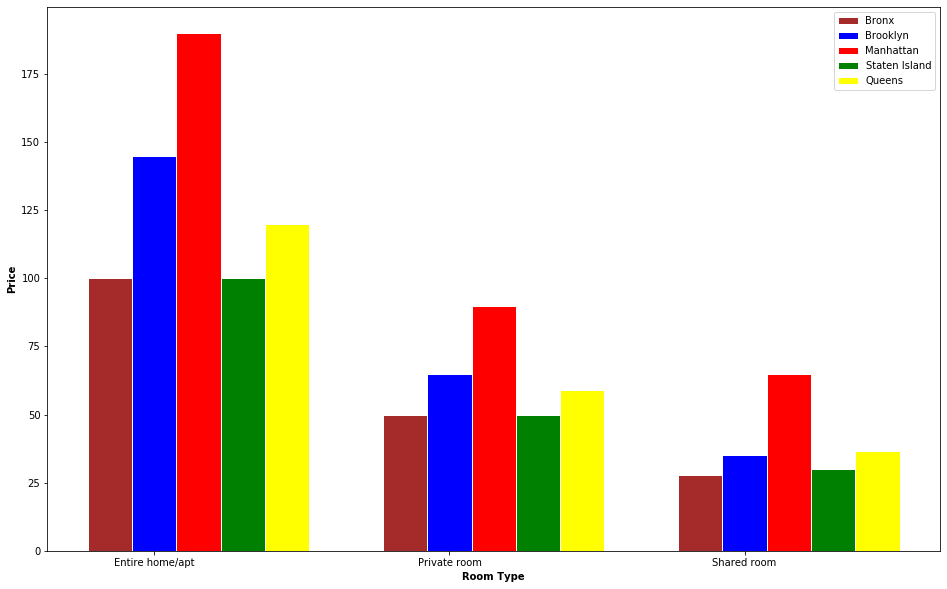

In [16]:
room_trend = airbnb_df[airbnb_df["new_listing_flag"] == 0].groupby([ "neighbourhood_group","room_type"])["price"].median().reset_index()
room_trend.set_index(["room_type"]).reset_index().sort_values(by=["neighbourhood_group","room_type"])

room_trend = pd.DataFrame(room_trend)
room_trend = pd.pivot_table(room_trend,values="price",columns="neighbourhood_group",index="room_type").fillna(value=0)

plt.figure(figsize=(16, 10))

barWidth = 0.15  # the width of the bar
# set height of bar
bars1 = room_trend["Bronx"].tolist()
bars2 = room_trend["Brooklyn"].tolist()
bars3 = room_trend["Manhattan"].tolist()
bars4 = room_trend["Staten Island"].tolist()
bars5 = room_trend["Queens"].tolist()

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

plt.bar(r1, bars1, color='brown', width=barWidth, edgecolor='white', label='Bronx')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='Brooklyn')
plt.bar(r3, bars3, color='red', width=barWidth, edgecolor='white', label='Manhattan')
plt.bar(r4, bars4, color='green', width=barWidth, edgecolor='white', label='Staten Island')
plt.bar(r5, bars5, color='yellow', width=barWidth, edgecolor='white', label='Queens')

plt.xlabel('Room Type', fontweight='bold')
plt.ylabel('Price', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], room_trend.index)

plt.legend()
plt.show()

We know that entire homes fetch a higher price than semi-private spaces. But the difference between boroughs is again pronounced here. For the same price as a private room in Manhattan, you can get a whole apartment if you move to the Bronx or Staten Island.

** 3. Listing Description Analysis **

I'm interested in understanding the qualitative features that set prices apart. What are some features that makes listings more desirable? 

To control for the difference between boroughs, we'll look into the features within each borough. We'll also dive deeper by controlling for other features such as type of room and the overall popularity of the listing.

In [19]:
# check the top word descriptions by prices
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

# function to clean up the descriptions
def filter_sentence(description):
    filtered_sentence = [w.lower() for w in description if not w in stop_words and not w in string.punctuation and w.isalpha()] 
    filtered_sentence = [w.replace("bd","bedroom") for w in filtered_sentence] 
    filtered_sentence = [w.replace("bedrooms","bedroom") for w in filtered_sentence]
    filtered_sentence = [w.replace("bath", "bathroom") for w in filtered_sentence]
    filtered_sentence = [w.replace("bathrooms", "bathroom") for w in filtered_sentence]
    return filtered_sentence

airbnb_df["name"] = ["" if isinstance(x, float) else x for x in airbnb_df["name"] ]

# create a new column for the cleaned up descriptions
airbnb_df["description"] = airbnb_df["name"].apply(word_tokenize)
stop_words = set(stopwords.words('english')) 
airbnb_df["description"] = airbnb_df["description"].apply(filter_sentence)

/Users/Bellyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/Bellyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Bellyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [20]:
# create a new row for each word in the description 
airbnb_df_expand = airbnb_df.explode("description")
airbnb_df_expand["description"] = [x if isinstance(x, str) else "" for x in airbnb_df_expand["description"]]
airbnb_df_expand.groupby("description")["description"].count().sort_values(ascending=False)

description
room          8417
bedroom       6698
private       6155
apartment     5580
cozy          4246
              ... 
mothership       1
mostly           1
mosholu          1
moses            1
longtermii       1
Name: description, Length: 5889, dtype: int64

In [21]:
# set cutoff to exclude statistically insignificant words
cutoff = 50

# overall most expensive listings, without controlling for anything
description_price = airbnb_df_expand.groupby("description")["price"].agg({'Count':'count','Min': 'min',
                             'Max': 'max', 'Median':'median', 'Std':'std'})

description_price = description_price.loc[description_price["Count"] > 50].sort_values(by="Median", ascending = False)

description_price

/Users/Bellyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


,Count,Min,Max,Median,Std
description,,,,,
service,64,78,956,699.0,221.649030
blueground,229,184,481,302.0,54.215222
tribeca,130,60,6500,293.0,618.117352
pool,105,49,748,275.0,113.968472
flatiron,63,70,2000,250.0,356.176101
...,...,...,...,...,...
budget,71,19,229,55.0,30.982432
ridgewood,87,20,375,50.0,60.130565
couch,52,10,300,50.0,53.708177


In [22]:
# various cuts controlling for selected features
segment_list = ["room_type", "neighbourhood_group", "binned_reviews","binned_reviews_per_month"]
segment_df = []
for s in segment_list:
    description_segment = airbnb_df_expand.groupby([s,"description"])["price"].agg({'Count':'count','Min': 'min',
                             'Max': 'max', 'Median':'median'})
    description_segment = description_segment.loc[description_segment["Count"] > cutoff].sort_values(by=[s,"Median"], ascending = False).groupby(s).head(5)
    segment_df.append(description_segment)

/Users/Bellyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


In [23]:
# view by controlled segment
segment_df[segment_list.index("neighbourhood_group")]

Count  Min   Max  Median
neighbourhood_group description                          
Staten Island       ferry           60   29   450    87.5
                    private         77   25   299    57.0
                    room            70   25   200    50.0
Queens              beach          102   35  1500   127.0
                    house          169   10  1500   125.0
                    luxury         120   30   900   119.5
                    floor           51   32  1500   108.0
                    entire          74   29   299   107.5
Manhattan           service         62   80   956   699.0
                    blueground     227  184   481   302.0
                    townhouse      166   58  7703   299.0
                    tribeca        130   60  6500   293.0
                    pool            81   65   748   282.0
Brooklyn            stunning        96   32  1749   199.5
                    duplex         464   30  6500   175.0
                    sleeps          63   80   995   175.0
                    views          133   20   650   172.0
                    condo          100   50   525   170.0
Bronx               apartment      133   20   500    90.0
                    nyc             77   22   399    85.0
                    yankee          51   23   350    80.0
                    studio          54   20   670    79.5
                    bedroom        119   28   680    75.0